# Skin color detection

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2

import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

## HAM

In [2]:
db = "HAM"
root = f"../../dataset/AAAI 2025/{db}/"
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [3]:
baseline = df_test.sample(n=1, random_state=12)
sample = df_test.sample(n=1, random_state=42)

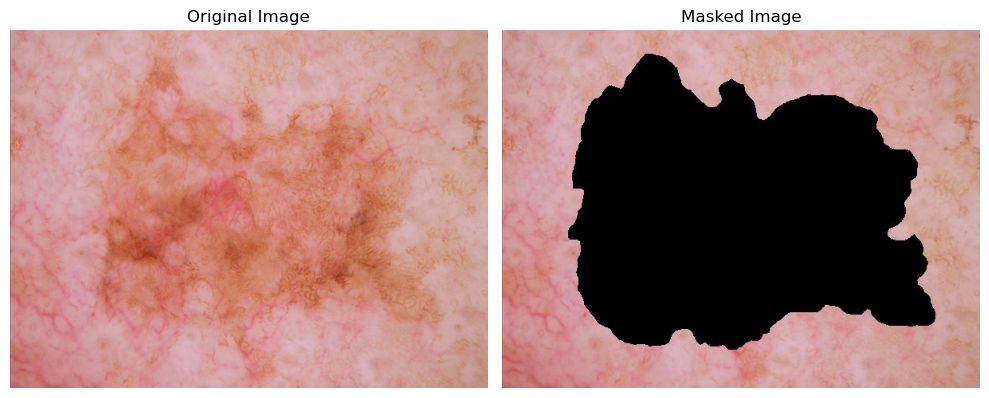

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

img = cv2.imread(baseline["filepath"].values[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masked_img = cv2.imread(baseline["masked filepath"].values[0])
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
        
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(masked_img)
axes[1].axis("off")
axes[1].set_title("Masked Image")

plt.tight_layout()
plt.show()

In [5]:
ita = IndividualTypologyAngle(masked_img)
baseline_mean_ita = ita.get_mean_ita()
print(f"Conventional ITA values: {baseline_mean_ita}")
baseline_nuance_ita = ita.get_nuance_ita()

Conventional ITA values: 84.99534274796993


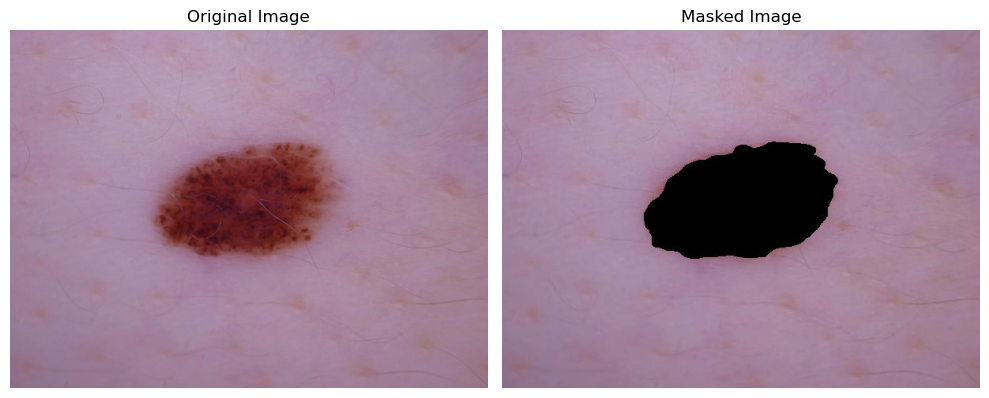

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

img = cv2.imread(sample["filepath"].values[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masked_img = cv2.imread(sample["masked filepath"].values[0])
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
        
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(masked_img)
axes[1].axis("off")
axes[1].set_title("Masked Image")

plt.tight_layout()
plt.show()

In [7]:
ita = IndividualTypologyAngle(masked_img)
sample_mean_ita = ita.get_mean_ita()
print(f"Conventional ITA values: {sample_mean_ita}")
sample_nuance_ita = ita.get_nuance_ita()

Conventional ITA values: 129.52674615128467


In [12]:
# Plot Baseline vs Sample images

def plot_baseline_vs_sample(baseline_nuance_ita, sample_nuance_ita):
    baseline_nuance_ita_series = pd.Series(baseline_nuance_ita)
    sample_nuance_ita_series = pd.Series(sample_nuance_ita)
    max_length = max(len(baseline_nuance_ita_series), len(sample_nuance_ita_series))
    baseline_nuance_ita_series = baseline_nuance_ita_series.reindex(range(max_length))
    sample_nuance_ita_series = sample_nuance_ita_series.reindex(range(max_length))
    
    plt.figure(figsize=(8, 3))
    
    df_plot = pd.DataFrame({
        "baseline": baseline_nuance_ita_series,
        "sample": sample_nuance_ita_series
    })
    
    sns.kdeplot(df_plot["baseline"], fill=True, color="r", label="Baseline")
    sns.kdeplot(df_plot["sample"], fill=True, color="b", label="Sample")
    plt.xlabel("Skin gradation distance")
    plt.ylabel("Colour density")
    plt.legend(loc="upper left")
    plt.show()

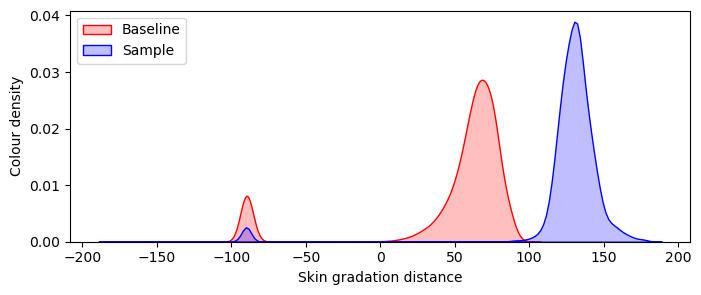

In [13]:
plot_baseline_vs_sample(baseline_nuance_ita, sample_nuance_ita)

In [29]:
dm = DistanceMeasure(baseline_nuance_ita, sample_nuance_ita)
distance = dm.sign_wasserstein_distance()
print(f"Distance between baseline and sample: ", distance)

Distance between baseline and sample:  -75.55976506383793


In [34]:
distances = []

for _, row in df_test.iterrows():
    
    skin_pixels_image = cv2.imread(row["masked filepath"])
    skin_pixels_image = cv2.cvtColor(skin_pixels_image, cv2.COLOR_BGR2RGB)
    
    if skin_pixels_image is None:
        # print(_)
        distances.append(np.nan)
    else:
        ita = IndividualTypologyAngle(skin_pixels_image)
        nuance_ita = ita.get_nuance_ita()
        dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
        distance = distance = dm.sign_wasserstein_distance()
        distances.append(distance)

In [35]:
num_nans = np.sum(np.isnan(distances))
print(f"Number of np.nan values in 'distance': {num_nans}")

Number of np.nan values in 'distance': 0


In [36]:
df_test["distance"] = distances
index = df_test[df_test["distance"].isnull()].index
df_test.drop(index=index, inplace=True)
df_test.to_csv(f"{root}/dataframe/df_test_with_skincolor.csv", index=False)

## CelebA

In [14]:
db = "CelebA"
root = f"../../dataset/AAAI 2025/{db}/"
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

### Skin color detection - baseline

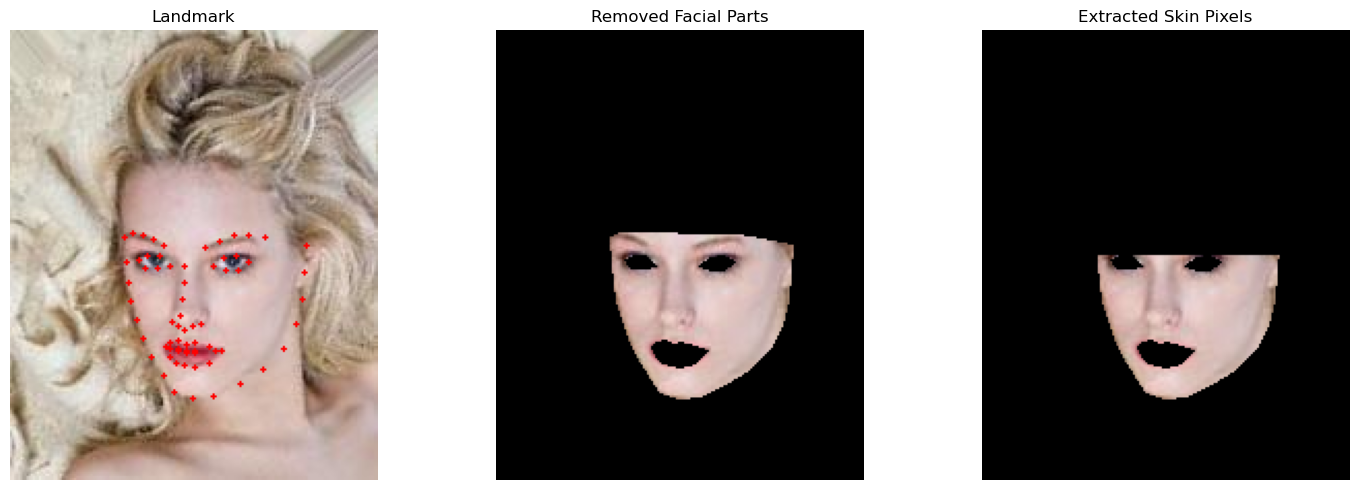

In [15]:
baseline = df_test.sample(n=1, random_state=12)
baseline_filepath = baseline["filepath"].values[0]

se = SkinExtraction(baseline_filepath)
se.display_process_images()

In [16]:
base_line_skin_pixels_image = se.extract_skin_pixels()
ita = IndividualTypologyAngle(base_line_skin_pixels_image)
baseline_mean_ita = ita.get_mean_ita()
print(f"Conventional ITA values: {baseline_mean_ita}")
baseline_nuance_ita = ita.get_nuance_ita()

Conventional ITA values: 89.90706664031187


### Skin color detection - sample comparison

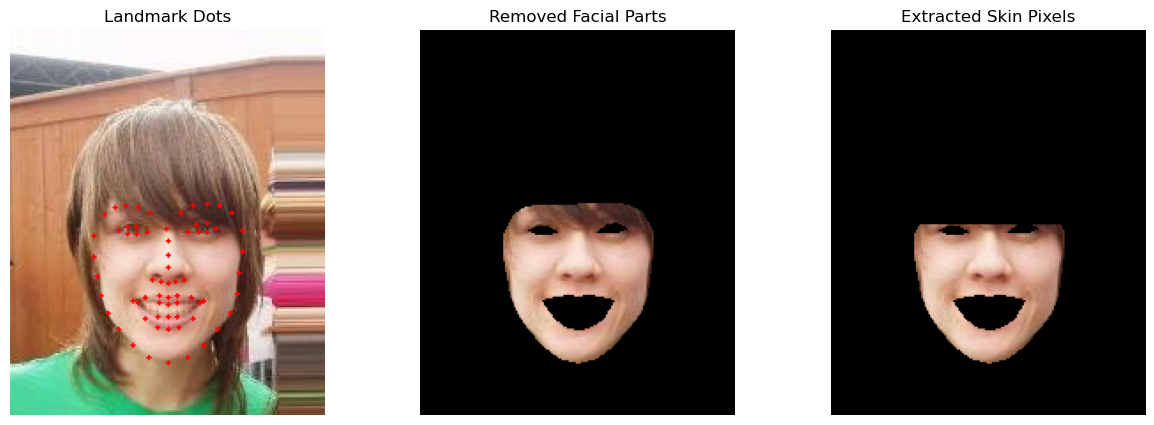

In [17]:
sample = df_test.sample(n=1, random_state=82)
sample_filepath = sample["filepath"].values[0]

se = SkinExtraction(sample_filepath)
landmark_dot_image = se.create_landmark_image()
mask_image = se.remove_facial_parts()
sample_skin_pixels_image = se.extract_skin_pixels()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

axes[0].imshow(landmark_dot_image)
axes[0].axis('off')
axes[0].set_title('Landmark Dots')
axes[1].imshow(mask_image)
axes[1].axis('off')
axes[1].set_title('Removed Facial Parts')
axes[2].imshow(sample_skin_pixels_image)
axes[2].axis('off')
axes[2].set_title('Extracted Skin Pixels')

ita = IndividualTypologyAngle(sample_skin_pixels_image)
sample_mean_ita = ita.get_mean_ita()
sample_nuance_ita = ita.get_nuance_ita()

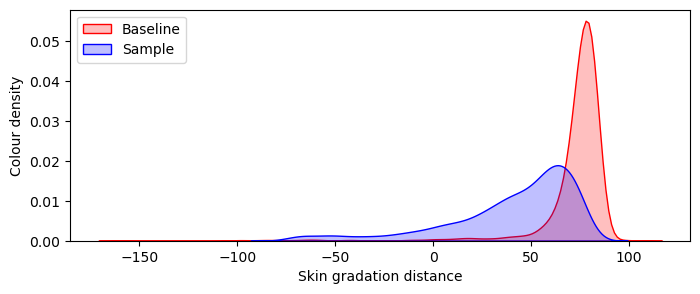

In [18]:
plot_baseline_vs_sample(baseline_nuance_ita, sample_nuance_ita)

In [8]:
dm = DistanceMeasure(baseline_nuance_ita, sample_nuance_ita)
distance = dm.sign_wasserstein_distance()
print(f"Distance between baseline and sample: ", distance)

Distance between baseline and sample:  31.9106843723218


### Apply all test dataset

In [9]:
means = []
distances = []

for _, row in df_test.iterrows():
    
    se = SkinExtraction(row["filepath"])
    skin_pixels_image = se.extract_skin_pixels()
    
    if skin_pixels_image is None:
        # print(_)
        means.append(np.nan)
        distances.append(np.nan)
    else:
        ita = IndividualTypologyAngle(skin_pixels_image)
        means.append(ita.get_mean_ita())
        nuance_ita = ita.get_nuance_ita()

        dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
        distance = distance = dm.sign_wasserstein_distance()
        distances.append(distance)

In [10]:
num_nans = np.sum(np.isnan(means))
print(f"Number of np.nan values in 'means': {num_nans}")

Number of np.nan values in 'means': 116


In [11]:
df_test["mean ita"] = means
df_test["distance"] = distances
index = df_test[df_test["mean ita"].isnull()].index
df_test.drop(index=index, inplace=True)
df_test.to_csv(f"{root}/dataframe/df_test_with_skincolor.csv", index=False)

## UTKFace

In [12]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

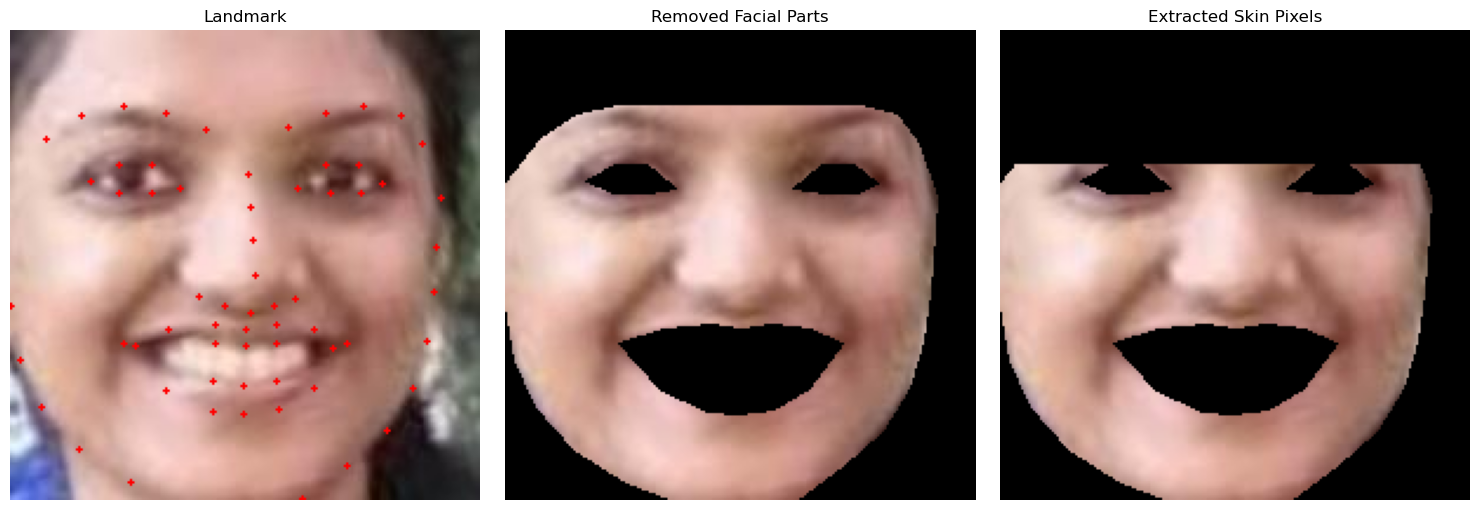

In [13]:
baseline = df_test.sample(n=1, random_state=12)
baseline_filepath = baseline["filepath"].values[0]

se = SkinExtraction(baseline_filepath)
se.display_process_images()

In [14]:
means = []
distances = []

for _, row in df_test.iterrows():
    
    se = SkinExtraction(row["filepath"])
    skin_pixels_image = se.extract_skin_pixels()
    
    if skin_pixels_image is None:
        # print(_)
        means.append(np.nan)
        distances.append(np.nan)
    else:
        ita = IndividualTypologyAngle(skin_pixels_image)
        means.append(ita.get_mean_ita())
        nuance_ita = ita.get_nuance_ita()

        dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
        distance = dm.sign_wasserstein_distance()
        distances.append(distance)

In [15]:
num_nans = np.sum(np.isnan(means))
print(f"Number of np.nan values in 'means': {num_nans}")

Number of np.nan values in 'means': 253


In [16]:
df_test["mean ita"] = means
df_test["distance"] = distances
index = df_test[df_test["mean ita"].isnull()].index
df_test.drop(index=index, inplace=True)
df_test.to_csv(f"{root}/dataframe/df_test_with_skincolor.csv", index=False)